In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
plot_dir = '/hpc/compgen/users/mpages/babe/plot_notebooks/global_performance'

In [3]:
from tqdm import tqdm

In [4]:
model_dir_global = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/models/grid_analysis/global'
model_dir_human = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/models/grid_analysis/human'

In [5]:
all_results_global = list()
all_results_human = list()


for i, modelname in tqdm(enumerate(os.listdir(model_dir_global)), total = len(os.listdir(model_dir_global))):
    report = dict()
    try:
        all_results_global.append(pd.read_csv(
            os.path.join(
                model_dir_global,
                modelname,
                'reports_400_1_0.1',
                'report_'+modelname+'_singlevalues.csv'
            ),
            header = 0,
            comment = '#'
        ))
        all_results_human.append(pd.read_csv(
            os.path.join(
                model_dir_human,
                modelname,
                'reports_400_1_0.1',
                'report_'+modelname+'_singlevalues.csv'
            ),
            header = 0,
            comment = '#'
        ))
    except FileNotFoundError:
        continue

dl = list()
for l in [all_results_global, all_results_human]:

    df = pd.concat(l)
    df = df.rename(columns = {'model':'modelname'})
    df = df.pivot(index='modelname', columns='metric', values='value')

    df = df.rename(
        columns = {
            'pass':'Evaluated',
            'failedmapping':'Failed alignment',
            'shortalignment':'Short alignment',
            'noprediction':'No prediction',
            'match_rate': 'Match',
            'mismatch_rate': 'Mismatch',
            'insertion_rate': 'Insertion',
            'deletion_rate': 'Deletion',        
            'homopolymer_errorrate_A': 'Adenine',
            'homopolymer_errorrate_C': 'Cytosine',
            'homopolymer_errorrate_G': 'Guanine',
            'homopolymer_errorrate_T': 'Thymine',
            'phredq_overlap': 'PhredQ overlap',
            'auc': 'AUC',
        }
    )

    df['Convolution'] = np.char.upper(np.array(df.index.str.split('_').tolist())[:, 0])
    df['Encoder'] = np.char.upper(np.array(df.index.str.split('_').tolist())[:, 1])
    df['Decoder'] = np.char.upper(np.array(df.index.str.split('_').tolist())[:, 2])
    df = df.reset_index()
    dl.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 167.82it/s]


# Names

In [8]:
colorcode_convolution = {
    'BONITO':'#FF0000', #red
    'SACALL':'#FF5656', #red
    'CATCALLER':'#FFA3A3', #red
    'URNANO':'#fff700', #orange
    'CAUSALCALL':'#fffb87', #orange
    'MINCALL':'#fffdcf', #orange
}

namecode_convolution = {
    'BONITO':'BON', #red
    'SACALL':'SAC', #red
    'CATCALLER':'CAT', #red
    'URNANO':'URN', #orange
    'CAUSALCALL':'CAU', #yellow
    'MINCALL':'MIN', #yellow
}

colorcode_encoder = {
    'BONITOFWD':'#0053FE', #blue
    'BONITOREV':'#6E9DFF', #blue
    'SACALL':'#01FF00', #Green
    'CATCALLER':'#9AFFA0', #Green
    'LSTM1':'#A300FF', #purple
    'LSTM3':'#C45BFF', #purple
    'LSTM5':'#E1ABFF', #purple
    'URNANO':'#fff700', #orange
}

namecode_encoder = {
    'BONITOFWD':'BFW', #blue
    'BONITOREV':'BRE', #blue
    'SACALL':'SAC', #Green
    'CATCALLER':'CAT', #Green
    'LSTM1':'LS1', #purple
    'LSTM3':'LS3', #purple
    'LSTM5':'LS5', #purple
    'URNANO':'URN', #orange
}

colorcode_decoder = {
    'CRF': "#787878", #black
    'CTC': "#BABABA" #grey
}

namecode_decoder = {
    'CRF': "CRF", #black
    'CTC': "CTC" #grey
}

In [9]:
ranks = list()
medal_colors = ["#CD7F32", "#C0C0C0", '#d4af37']
all_columns = [
    ['Evaluated', 'Failed alignment', 'Short alignment', 'No prediction'],
    ['Match', 'Mismatch', 'Insertion', 'Deletion'],
    ['Adenine', 'Cytosine', 'Guanine', 'Thymine'],
    ['AUC', 'PhredQ overlap'],

]
better = {
    'Evaluated': 'max',
    'Failed alignment': 'min',
    'Short alignment': 'min',
    'No prediction': 'min',
    'Match': 'max',
    'Mismatch': 'min',
    'Insertion': 'min',
    'Deletion': 'min',
    'Adenine':'min', 
    'Cytosine':'min', 
    'Guanine':'min', 
    'Thymine':'min',
    'AUC': 'max',
    'PhredQ overlap': 'min',
}

df = dl[0]
for columns in all_columns:
    ranks.append(ranker(df, columns, better)[1])
final_order = np.argsort(-np.concatenate(ranks, axis = 1).sum(1))

In [10]:
names_rgb = np.zeros((df.shape[0],3, 3), dtype=float)
names_codes = np.zeros((df.shape[0], 3), dtype='U3')


for i, (_, row) in enumerate(df.iterrows()):
    names_rgb[i, 0, :] = matplotlib.colors.to_rgb(colorcode_convolution[row['Convolution']])
    names_rgb[i, 1, :] = matplotlib.colors.to_rgb(colorcode_encoder[row['Encoder']])
    names_rgb[i, 2, :] = matplotlib.colors.to_rgb(colorcode_decoder[row['Decoder']])

    names_codes[i, 0] = namecode_convolution[row['Convolution']]
    names_codes[i, 1] = namecode_encoder[row['Encoder']]
    names_codes[i, 2] = namecode_decoder[row['Decoder']]

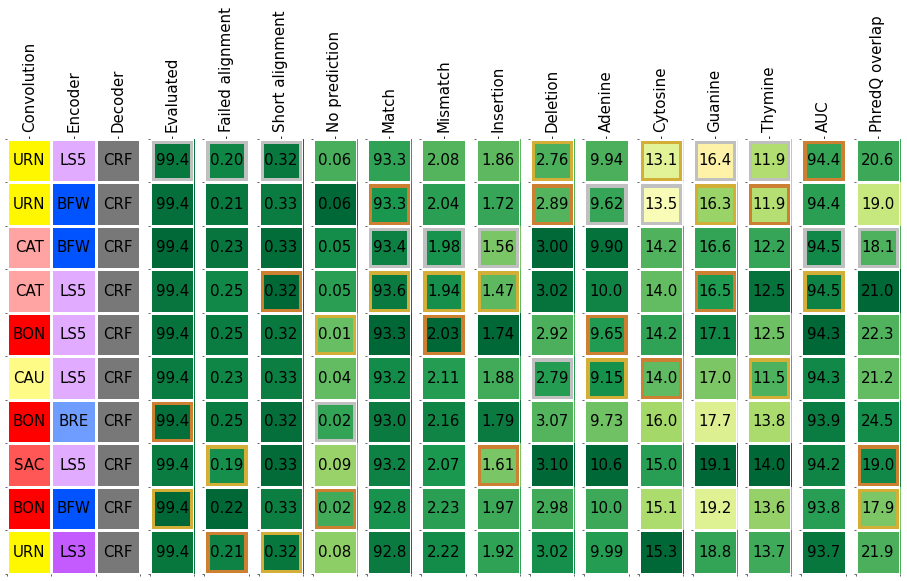

In [19]:
fig, axes = plt.subplots(nrows = 1, ncols = 15, figsize=(16, 8), sharey = True, gridspec_kw={'width_ratios':[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})
im = axes[0].imshow(names_rgb[final_order,])
axes[0].set_yticks([])

axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['Convolution', 'Encoder', 'Decoder'], rotation = 90, fontsize=15)

axes[0].spines[:].set_visible(False)
axes[0].set_xticks(np.arange(names_rgb.shape[1]+1)-0.5, minor=True)
axes[0].set_yticks(np.arange(names_rgb.shape[0]+1)-0.5, minor=True)
axes[0].grid(which="minor", color="w", linestyle='-', linewidth=3)
axes[0].tick_params(axis = 'x', top = True, bottom = False, labelbottom=False,labeltop=True)
axes[0].tick_params(axis='y', colors='white')
axes[0].set_aspect('auto')

annotate_heatmap_names(im, names_codes[final_order,], fontsize=15)

for i, columns in enumerate(list(np.concatenate(all_columns).flat)):
    i += 1
    x = np.array(df[columns])
    x_h = np.array(dl[1][columns])
    x = np.expand_dims(x, 1)
    x_h = np.expand_dims(x_h, 1)
    arr = x-x_h[final_order, ]
    x, x_order = ranker(df, [columns], better)

    if better[columns] == 'min':
        arr = - arr
    vmax = np.max(np.abs(arr))
    vmin = -vmax
          
    im = axes[i].imshow(arr, cmap = 'RdYlGn', vmin = vmin, vmax = vmax)
    
    axes[i].set_yticks([])
    axes[i].set_xticks([0])
    axes[i].set_xticklabels([columns], rotation = 90, fontsize=15)

    axes[i].spines[:].set_visible(False)
    axes[i].set_xticks(np.arange(x.shape[1]+1)-0.5, minor=True)
    axes[i].set_yticks(np.arange(x.shape[0]+1)-0.5, minor=True)
    axes[i].tick_params(axis='x', colors='black')
    axes[i].tick_params(axis='y', colors='white')

    axes[i].grid(which="minor", color="w", linestyle='-', linewidth=3)
    axes[i].tick_params(axis = 'x', top = True, bottom = False, labelbottom=False,labeltop=True)

    annotate_heatmap_values(im, x[final_order,], fontsize=15)
    axes[i].set_aspect('auto')

    x_order = x_order[final_order,]

    for k in range(x_order.shape[1]):
        s = x_order[:, k]
        best = np.sort(s)[-3:]
        for j, b in enumerate(best):
            p = np.where(s == b)[0]
            for pp in p:
                rect = patches.Rectangle((-0.45+k, pp-0.45), 0.9, 0.9, linewidth=5, edgecolor=medal_colors[j], facecolor='none')
                axes[i].add_patch(rect)

# cbar = plt.colorbar(im, ax=axes, aspect = 30, )
# cbar.ax.get_yaxis().set_ticks([vmin, 0, vmax])
# cbar.ax.set_yticklabels(['Worse', 'Unchanged', 'Better'])
# cbar.set_label('Performance change')

fig.savefig(os.path.join(plot_dir, 'global_performance_table_nolegend.pdf'), dpi = 600)
plt.show()

In [20]:
df['Task'] = 'Global'
dl[1]['Task'] = 'Human'
df2 = pd.concat([df, dl[1]])

In [21]:
df['Convolution_type'] = 'Simple'
df.loc[df['Convolution'] == 'MINCALL','Convolution_type'] = 'Complex'
df.loc[df['Convolution'] == 'URNANO','Convolution_type'] = 'Complex'
df.loc[df['Convolution'] == 'CAUSALCALL','Convolution_type'] = 'Complex'

df['Encoder_type'] = 'RNN'
df.loc[df['Encoder'] == 'SACALL', 'Encoder_type'] = 'Transformer'
df.loc[df['Encoder'] == 'CATCALLER', 'Encoder_type'] = 'Transformer'

conv_pos = dict()
for i, conv in enumerate(np.unique(df['Convolution'])):
    conv_pos[conv] = i

conv_type = dict()
for k in np.unique(df['Encoder']):
    if k in ['SACALL', 'CATCALLER']:
        conv_type[k] = 'o'
    else:
        conv_type[k] = 's' 
enc_type = {
    'BONITOFWD':'>',
    'BONITOREV': '<',
    'LSTM3': 's',
    'LSTM5': 'p',
}

metric_name_transformer = {
    'Match': 'Match rate',
    'Mismatch': 'Mismatch rate',
    'Insertion': 'Insertion rate',
    'Deletion': 'Deletion rate',
}

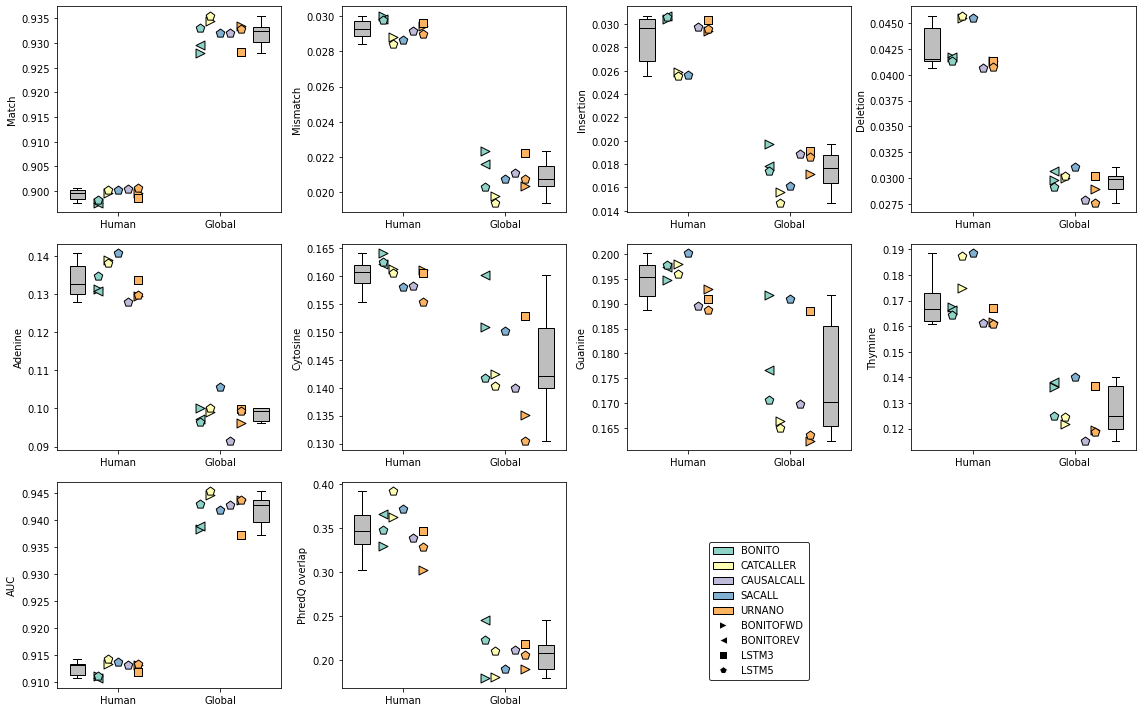

In [27]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

conv_pos = {
    'BONITO': -2,
    'CATCALLER': -1,
    'SACALL': 0,
    'CAUSALCALL': 1,
    'URNANO': 2,
}

colorpalettetab10 = [
    (0.5529411764705883, 0.8274509803921568, 0.7803921568627451), 
    (1.0, 1.0, 0.7019607843137254), 
    (0.7450980392156863, 0.7294117647058823, 0.8549019607843137), 
    (0.5019607843137255, 0.6941176470588235, 0.8274509803921568), 
    (0.9921568627450981, 0.7058823529411765, 0.3843137254901961), 
   (0.7019607843137254, 0.8705882352941177, 0.4117647058823529)
]
convolutions = np.unique(df['Convolution'])
c_dict = dict()
for i, cnv in enumerate(convolutions):
    c_dict[cnv] = colorpalettetab10[i]

fig, axes = plt.subplots(3, 4, figsize = (16, 10))

for axnum, (ax, metric) in enumerate(zip(axes.flatten(), 
    [
        'Match',
        'Mismatch', 
        'Insertion', 
        'Deletion',
        'Adenine',
        'Cytosine', 
        'Guanine', 
        'Thymine',
        'AUC',
        'PhredQ overlap'
    ])):
    modelnames = list()
    vals = {
        'Simple': list(),
        'Complex': list()
    }
    if axnum >= 10:
        continue
    for i, row in df2.iterrows():
        modelname = row['modelname']
        p = conv_pos[row['Convolution']]/10
        if not 'crf' in modelname:
            continue

        if row['Task'] == 'Global':
            p += 1
            vals['Complex'].append(row[metric])
        else:
            vals['Simple'].append(row[metric])

        
        
        ax.scatter(
            [p], 
            [
                row[metric],
            ], 
            color = c_dict[row['Convolution']],
            alpha = 1,
            zorder = 1,
            linewidth = 1,
            edgecolor='black',
            marker = enc_type[row['Encoder']],
            s = 80
        )

        
    bp = ax.boxplot(
        x = [vals['Simple'], vals['Complex']],
        positions = [-0.4, 1.4],
        showfliers = False,
        patch_artist = True,
        widths = [0.15, 0.15]
    )

    ax.set_ylabel(metric)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Human', 'Global'])
    ax.set_xlim(-0.6, 1.6)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black',  linewidth=1)
    plt.setp(bp['boxes'], facecolor = '#BEBEBE')

handles, labels = plt.gca().get_legend_handles_labels()

for c, n in zip(colorpalettetab10, list(c_dict.keys())):
    handles.extend([mpatches.Patch(facecolor=c, label=n, edgecolor = 'black', linewidth=1)]) 

for c, n in enc_type.items():
    handles.extend([
        Line2D([0], [0], marker=n, color='white', label=c, markerfacecolor='black', markersize=8)
    ])



lgd = fig.legend(handles=handles, edgecolor = 'black', bbox_to_anchor=(0.7,0.05), loc="lower right", borderaxespad=0)
fig.tight_layout()
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][3])
fig.savefig(os.path.join(plot_dir, 'global_vs_human.pdf'), dpi = 600, bbox_extra_artists=(lgd,))
plt.show()

In [144]:
for metric in [
        'Match',
        'Mismatch', 
        'Insertion', 
        'Deletion',
        'Adenine',
        'Cytosine', 
        'Guanine', 
        'Thymine',
        'AUC',
        'PhredQ overlap'
    ]:

    print(metric)
    print(np.mean(df[metric] - dl[1][metric])) 

Match
0.03266791888267886
Mismatch
-0.00839570763819961
Insertion
-0.01128556493299281
Deletion
-0.01300697055838278
Adenine
-0.034990554352352626
Cytosine
-0.01595475244102123
Guanine
-0.020002833111842484
Thymine
-0.042342435486166174
AUC
0.02941965024499118
PhredQ overlap
-0.14335668537126703


# Funcs

In [6]:
def ranker(df, columns, better):

    # higher pos is better
    x = np.array(df[columns])
    if len(x.shape) == 1:
        x = np.expand_dims(x, 1)
    x_order = np.zeros(x.shape, dtype= int)
    if not isinstance(columns, list):
        columns = [columns]
    for i, col in enumerate(columns):
        
        if better[col] == 'max':
            x_order[:, i] = np.argsort(np.argsort(x[:, i]))
        elif better[col] == 'min':
            x_order[:, i] = np.argsort(np.argsort(-x[:, i]))
    x_order = x_order/np.max(x_order)

    return x, x_order



def annotate_heatmap_names(im, annotation, valfmt="{x:.2%}", threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, annotation[i, j], **kw)
            texts.append(text)

    return texts

def annotate_heatmap_values(im, values, valfmt="{x:.1%}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    data = im.get_array()
    data = data-np.mean(data)

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):

        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if values[i, j] >= 0.1:
                valfmt = matplotlib.ticker.StrMethodFormatter('{x:.1%}')
            else:
                valfmt = matplotlib.ticker.StrMethodFormatter('{x:.2%}')
            kw.update(color=textcolors[int(im.norm(np.abs(data[i, j])) < threshold)])
            text = im.axes.text(j, i, valfmt(values[i, j], None)[:-1], **kw)
            texts.append(text)

    return texts